<a href="https://colab.research.google.com/github/sulimankhan587/UAV-Joint-Design/blob/main/FL_UAV_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UAV Joint Design**

### Importing Libraries

In [ ]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 5]

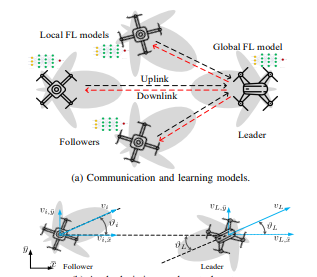

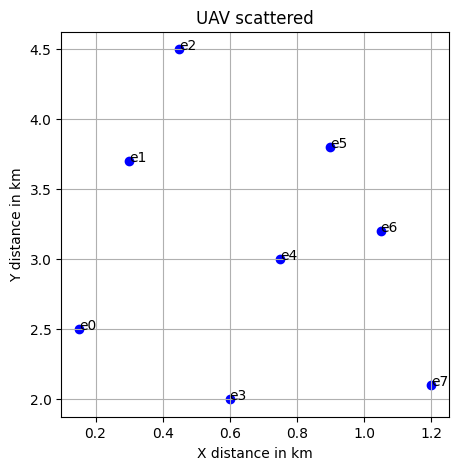

In [ ]:
import matplotlib.pyplot as plt

y = [2.5, 3.7, 4.5, 2, 3.0, 3.8, 3.2,2.1]
z = [0.15, 0.3, 0.45, 0.6, 0.75,0.90,1.05,1.20]
n = ["e0","e1", "e2", "e3", "e4", "e5","e6","e7"]

fig, ax = plt.subplots()
ax.scatter(z, y,color = 'b',label='nodes')
ax.grid()
plt.title("UAV scattered")
plt.xlabel("X distance in km")
plt.ylabel("Y distance in km")

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

In [ ]:
import math
import pandas as pd
import numpy as  np

array=[]
for i in range(len(z)):
  p1=[z[i],y[i]]
  try:
    if i==len(z)-1:
      p2=[1,1]
    else:
      p2=[z[i+1],y[i+1]]
    distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )
    t=[]
    t.append("Ex")
    t.append(n[i])
    t.append(str(round(distance,2)))
    array.append(t)
    #print(n[i]+" to "+n[k+1]+" distance =  "+ str(round(distance,2))+" km")
  except:
    pass

my_array = np.array(array)

dz = pd.DataFrame(my_array, columns = ['Leading UAVs','Follower UAV','distance (km)'])
#dz.to_csv("distance.csv", encoding='utf-8', index=False)
dz

,Leading UAVs,Follower UAV,distance (km)
0,Ex,e0,1.21
1,Ex,e1,0.81
2,Ex,e2,2.5
3,Ex,e3,1.01
4,Ex,e4,0.81
5,Ex,e5,0.62
6,Ex,e6,1.11
7,Ex,e7,1.12


### Load Dataset

In [ ]:
train_dataset = MNIST('/kaggle/working', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST('/kaggle/working', train=False, download=True, transform=transforms.ToTensor())

train_dataset, dev_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.83), int(len(train_dataset) * 0.17)])

100%|██████████| 9912422/9912422 [00:00<00:00, 246351227.41it/s]

Extracting /kaggle/working/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 32054960.00it/s]


Extracting /kaggle/working/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 112435236.49it/s]

Extracting /kaggle/working/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16022311.83it/s]


Extracting /kaggle/working/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/MNIST/raw



### Define Notebook Constants

In [ ]:
total_train_size = len(train_dataset)
total_test_size = len(test_dataset)
total_dev_size = len(dev_dataset)

classes = 10
input_dim = 784

num_clients = 8
rounds = 30
batch_size = 128
epochs_per_client = 3
learning_rate = 2e-2

In [ ]:
total_train_size, total_dev_size, total_test_size

(49800, 10200, 10000)

### Define utilities for GPU support

In [ ]:
def get_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader(DataLoader):
        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            for batch in self.dl:
                yield to_device(batch, self.device)

        def __len__(self):
            return len(self.dl)

device = get_device()

### Define FederatedNet class containing ML model

In [ ]:
class FederatedNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, 7)
        self.conv2 = torch.nn.Conv2d(20, 40, 7)
        self.maxpool = torch.nn.MaxPool2d(2, 2)
        self.flatten = torch.nn.Flatten()
        self.linear = torch.nn.Linear(2560, 10)
        self.non_linearity = torch.nn.functional.relu
        self.track_layers = {'conv1': self.conv1, 'conv2': self.conv2, 'linear': self.linear}

    def forward(self, x_batch):
        out = self.conv1(x_batch)
        out = self.non_linearity(out)
        out = self.conv2(out)
        out = self.non_linearity(out)
        out = self.maxpool(out)
        out = self.flatten(out)
        out = self.linear(out)
        return out

    def get_track_layers(self):
        return self.track_layers

    def apply_parameters(self, parameters_dict):
        with torch.no_grad():
            for layer_name in parameters_dict:
                self.track_layers[layer_name].weight.data *= 0
                self.track_layers[layer_name].bias.data *= 0
                self.track_layers[layer_name].weight.data += parameters_dict[layer_name]['weight']
                self.track_layers[layer_name].bias.data += parameters_dict[layer_name]['bias']

    def get_parameters(self):
        parameters_dict = dict()
        for layer_name in self.track_layers:
            parameters_dict[layer_name] = {
                'weight': self.track_layers[layer_name].weight.data,
                'bias': self.track_layers[layer_name].bias.data
            }
        return parameters_dict

    def batch_accuracy(self, outputs, labels):
        with torch.no_grad():
            _, predictions = torch.max(outputs, dim=1)
            return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

    def _process_batch(self, batch):
        images, labels = batch
        outputs = self(images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        accuracy = self.batch_accuracy(outputs, labels)
        return (loss, accuracy)

    def fit(self, dataset, epochs, lr, batch_size=128, opt=torch.optim.SGD):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size, shuffle=True), device)
        optimizer = opt(self.parameters(), lr)
        history = []
        for epoch in range(epochs):
            losses = []
            accs = []
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                loss.detach()
                losses.append(loss)
                accs.append(acc)
            avg_loss = torch.stack(losses).mean().item()
            avg_acc = torch.stack(accs).mean().item()
            history.append((avg_loss, avg_acc))
        return history

    def evaluate(self, dataset, batch_size=128):
        dataloader = DeviceDataLoader(DataLoader(dataset, batch_size), device)
        losses = []
        accs = []
        with torch.no_grad():
            for batch in dataloader:
                loss, acc = self._process_batch(batch)
                losses.append(loss)
                accs.append(acc)
        avg_loss = torch.stack(losses).mean().item()
        avg_acc = torch.stack(accs).mean().item()
        return (avg_loss, avg_acc)

### UAV Client Class

In [ ]:
class Client:
    def __init__(self, client_id, dataset):
        self.client_id = client_id
        self.dataset = dataset

    def get_dataset_size(self):
        return len(self.dataset)

    def get_client_id(self):
        return self.client_id

    def train(self, parameters_dict):
        net = to_device(FederatedNet(), device)
        net.apply_parameters(parameters_dict)
        train_history = net.fit(self.dataset, epochs_per_client, learning_rate, batch_size)
        print('{}: Loss = {}, Accuracy = {}'.format(self.client_id, round(train_history[-1][0], 4), round(train_history[-1][1], 4)))
        return net.get_parameters()

# **Simulation parameters**

In [ ]:
Array=[["Number of followers I", "8"],
       ["Transmission power threshold pmax ", "0.5 W"],
       ["Maximum speed vmax", "max 20 m/s "],
       ["Energy consumption efficient k", "10^-28"],
       ["Number of cycles needed per bit C", "10^3"],
       ["Frequency of the CPU φ ", "10^9 cycles"],
       ["Time for each communication round Tr", "0.1s"],
       ["Side lobe gain Gmin, path loss exponent 	α", "−2 dB, 2.5"],
       ["Noise spectral density y0", "-174dBm/Hz"],
       ["Packet size Sw and Swi", "10kB"],
       ["Number of rotors q and the diameter r", "4, 0.254 m"],
       ["Power efficiency η and density % of the air", "air 70 %, 1.225 kg/m3"],
       ["Packet size Sw and Swi", "10kB"],
       ["Number of samples K, Energy limit", "1,000, 7,000 J"],
       ]
DATA = pd.DataFrame(Array, columns = ['Parameters','Values'])
DATA

,Parameters,Values
0,Number of followers I,8
1,Transmission power threshold pmax,0.5 W
2,Maximum speed vmax,max 20 m/s
3,Energy consumption efficient k,10^-28
4,Number of cycles needed per bit C,10^3
5,Frequency of the CPU φ,10^9 cycles
6,Time for each communication round Tr,0.1s
7,"Side lobe gain Gmin, path loss exponent \tα","−2 dB, 2.5"
8,Noise spectral density y0,-174dBm/Hz
9,Packet size Sw and Swi,10kB


### Setup clients

In [ ]:
examples_per_client = total_train_size // num_clients
client_datasets = random_split(train_dataset, [min(i + examples_per_client,
           total_train_size) - i for i in range(0, total_train_size, examples_per_client)])
clients = [Client('client_' + str(i), client_datasets[i]) for i in range(num_clients)]

### Start server

In [ ]:
global_net = to_device(FederatedNet(), device)
history = []
for i in range(rounds):
    print('Start Round {} ...'.format(i + 1))
    curr_parameters = global_net.get_parameters()
    new_parameters = dict([(layer_name, {'weight': 0, 'bias': 0}) for layer_name in curr_parameters])
    for client in clients:
        client_parameters = client.train(curr_parameters)
        fraction = client.get_dataset_size() / total_train_size
        for layer_name in client_parameters:
            new_parameters[layer_name]['weight'] += fraction * client_parameters[layer_name]['weight']
            new_parameters[layer_name]['bias'] += fraction * client_parameters[layer_name]['bias']
    global_net.apply_parameters(new_parameters)

    train_loss, train_acc = global_net.evaluate(train_dataset)
    dev_loss, dev_acc = global_net.evaluate(dev_dataset)
    print('After round {}, train_loss = {}, dev_loss = {}, dev_acc = {}\n'.format(i + 1, round(train_loss, 4),
            round(dev_loss, 4), round(dev_acc, 4)))
    history.append((train_loss, dev_loss))

Start Round 1 ...
client_0: Loss = 0.4684, Accuracy = 0.8592
client_1: Loss = 0.4868, Accuracy = 0.8435
client_2: Loss = 0.4504, Accuracy = 0.8657
client_3: Loss = 0.4579, Accuracy = 0.8672
client_4: Loss = 0.4785, Accuracy = 0.8557
client_5: Loss = 0.4623, Accuracy = 0.8614
client_6: Loss = 0.4688, Accuracy = 0.8557
client_7: Loss = 0.4387, Accuracy = 0.8684
After round 1, train_loss = 0.382, dev_loss = 0.3928, dev_acc = 0.8836

Start Round 2 ...
client_0: Loss = 0.29, Accuracy = 0.9132
client_1: Loss = 0.3084, Accuracy = 0.9049
client_2: Loss = 0.2881, Accuracy = 0.9184
client_3: Loss = 0.2763, Accuracy = 0.923
client_4: Loss = 0.2915, Accuracy = 0.9158
client_5: Loss = 0.3015, Accuracy = 0.9144
client_6: Loss = 0.2901, Accuracy = 0.9101
client_7: Loss = 0.2635, Accuracy = 0.9236
After round 2, train_loss = 0.2647, dev_loss = 0.2713, dev_acc = 0.9203

Start Round 3 ...
client_0: Loss = 0.2157, Accuracy = 0.9409
client_1: Loss = 0.2268, Accuracy = 0.9342
client_2: Loss = 0.2092, Accur

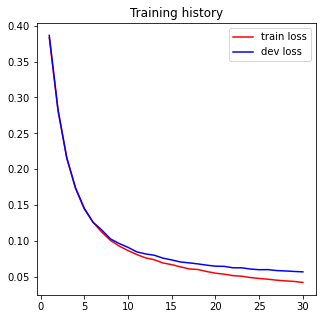

In [ ]:
plt.plot([i + 1 for i in range(len(history))], [history[i][0] for i in range(len(history))], color='r', label='train loss')
plt.plot([i + 1 for i in range(len(history))], [history[i][1] for i in range(len(history))], color='b', label='dev loss')
plt.legend()
plt.title('Training history')
plt.show()

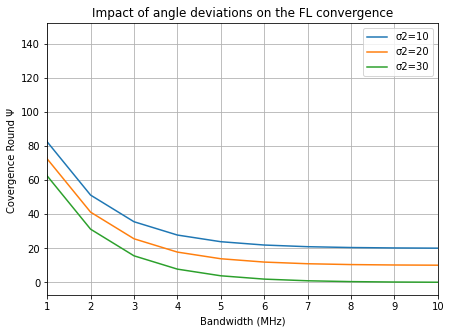

In [ ]:
import math
σ2=[]
y=[]
m=[]
k=[]
z=240
for i in range(100):
  σ2.append(i)
  z=(z-0)/2-5
  y.append(z+10)
  m.append(z+20)
  k.append(z+30)

plt.plot(σ2, k, label = "σ2=10")
plt.plot(σ2, m, label = "σ2=20")
plt.plot(σ2, y, label = "σ2=30")

plt.title("Impact of angle deviations on the FL convergence")
plt.xlabel("Bandwidth (MHz)")
plt.ylabel("Covergence Round Ψ ")
plt.xlim([1, 10])
plt.legend()
plt.grid()
plt.show()

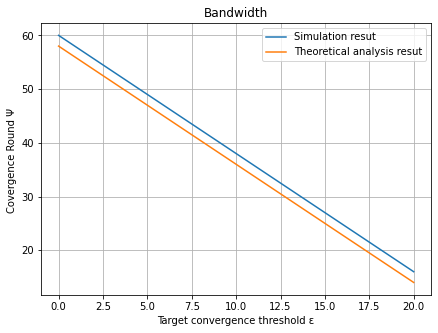

In [ ]:
import math
x=[]
Ψ=[]
ε=[]
for i in range(5):
  x.append(5*i)
  Ψ.append(60-(i*11))
  ε.append(60-(i*11)-2)
plt.rcParams["figure.figsize"] = (7,5)
plt.plot(x, Ψ, label = "Simulation resut")
plt.plot(x, ε, label = "Theoretical analysis resut")
plt.title("Bandwidth")
plt.xlabel("Target convergence threshold ε")
plt.ylabel("Covergence Round Ψ ")

plt.legend()
plt.grid()
plt.show()